# Analyse de données  <a class="tocSkip">

L'objectif de ce notebook est de mieux comprendre les données et analyses de l'article *Mutation dynamics and fitness effects followed in single cells*, par Lydia Robert, Jean Ollion, Jerome Robert, Xiaohu Song, Ivan Matic et Marina Elez (Science, 2018).

# Data exploration

In [4]:
library("gridExtra")
library("ggplot2")


## Mutation Accumulation experiment : data_microMA
### Files description

On se base sur les données fournies en annexe de l'article, ainsi que leur description.

The folder contains 4 files giving the evolution of growth rate during one representative $\mu$MA experiment for 4 different strains, *mutH*, *mutT*, WT, MF1 (dataset_microMA_...) . Each column contains the values of one variable (time, generation or growth rate) for each time step for the mother cell of a single microchannel. The first two lines (i.e. first two values for each column) give respectively the index of the field of view and the index of the microchannel (~15channels for each field of view).

In [5]:
microMA_WT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_WT.csv")
microMA_MutH <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv")

# Split the channel information (first 2 lines) from the growth rates
microMA_WT_channels <- microMA_WT[c(1,2),]
microMA_WT <- microMA_WT[-c(1,2),]
microMA_MutH_channels <- microMA_MutH[c(1,2),]
microMA_MutH <- microMA_MutH[-c(1,2),]


In [6]:
tail(microMA_MutH[,1:9], 10)

,time,generation,growth.rate,time.1,generation.1,growth.rate.1,time.2,generation.2,growth.rate.2
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
993,3960,182,0.02770213,3960,121,0.01443289,3960,163,0.001285689
994,3964,182,0.02770213,3964,121,0.01443289,3964,163,0.001285689
995,3968,182,0.02770213,3968,122,0.01675265,3968,164,0.026031184
996,3972,182,0.02770213,3972,122,0.01675265,3972,164,0.026031184
997,3976,182,0.02770213,3976,122,0.01675265,3976,164,0.026031184
998,3980,183,0.02867049,3980,122,0.01675265,3980,164,0.026031184
999,3984,183,0.02867049,3984,122,0.01675265,3984,165,0.025671465
1000,3988,183,0.02867049,3988,122,0.01675265,3988,165,0.025671465
1001,3992,183,0.02867049,3992,122,0.01675265,3992,165,0.025671465


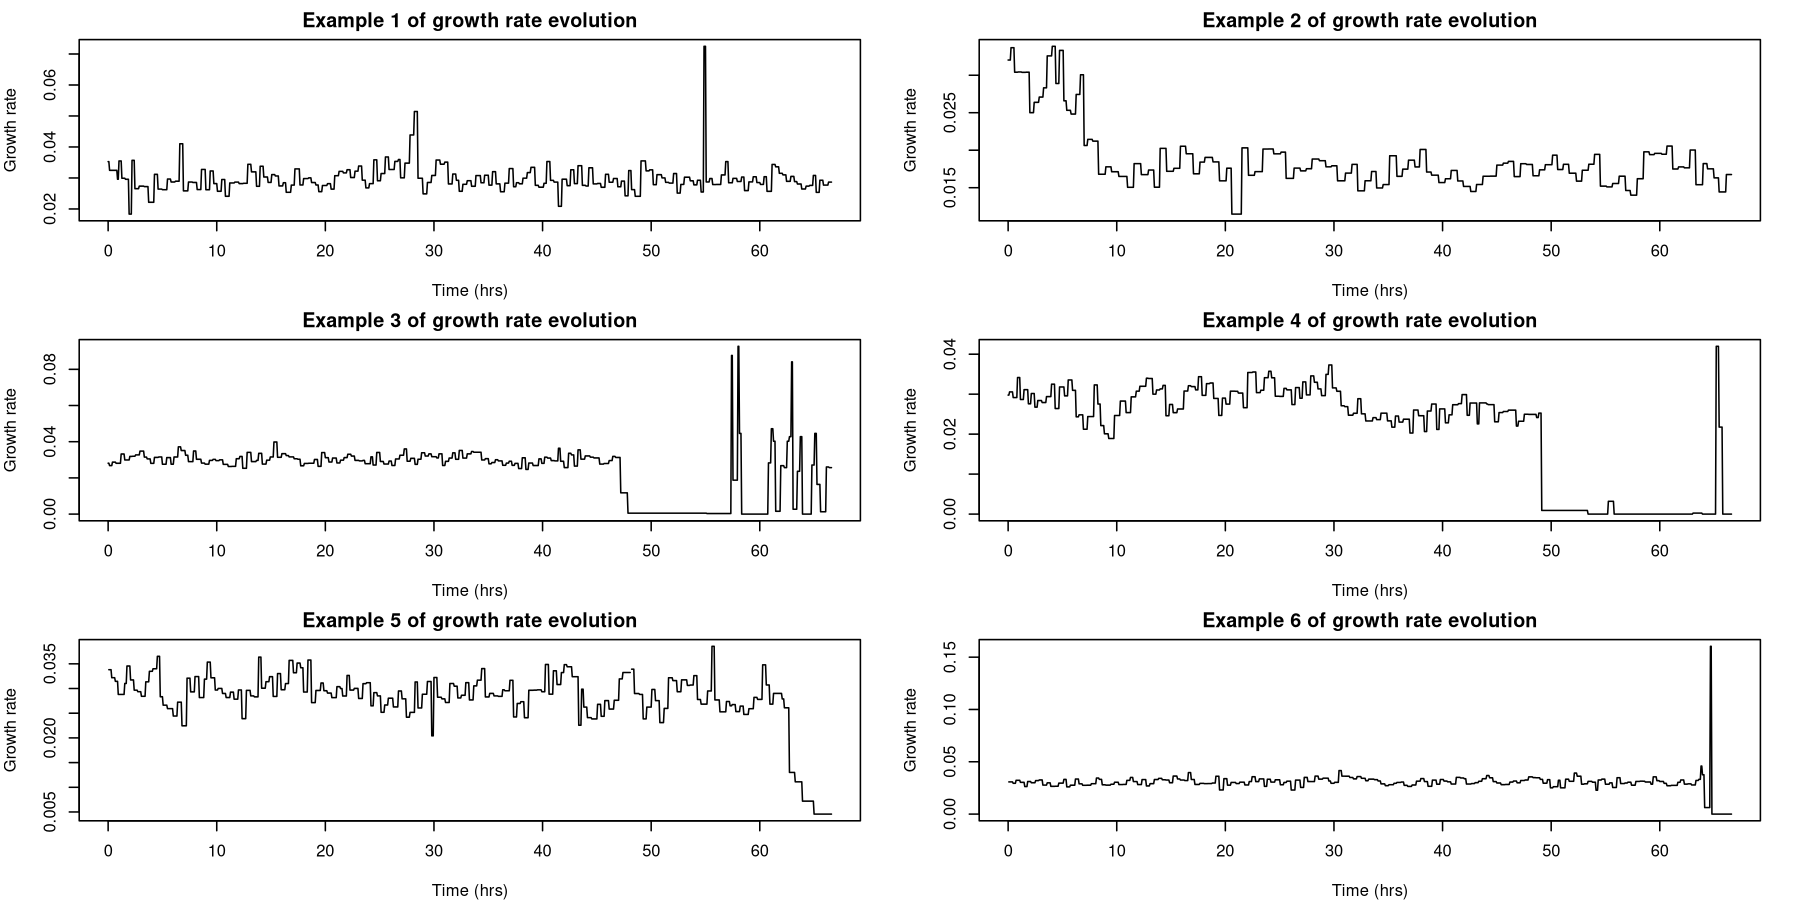

In [7]:
#png("Img/Growth_rates_examples.png", width = 800, height = 400)

microMA_MutH_growthRates <- microMA_MutH[seq(3, dim(microMA_MutH)[2], 3)]
microMA_MutH_growthRates[microMA_MutH_growthRates<0] <- 0  # Set negative growth rates to 0

par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:6){
    plot(microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

#dev.off()

## Traitement des données :

Full relevant text:

* The segmentation errors generated by image analysis can create aberrant, very low or high growth rates. Therefore, we filtered our data in the following way. For each channel and each generation, we calculated the median of the growth rates for earlier generations (M bef ore ) and subsequent generations (M af ter ). Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both M bef ore and M af ter or much smaller than both M bef ore and M af ter (Note that M bef ore and M af ter can be significantly different because of the occurrence of deleterious mutations). Therefore for each generation, we remove the value of the growth rate μ from the data if it di↵ers from both M af ter and M bef ore by more than a threshold value T. The value T was fixed at 30% of the average growth rate in the experiment, corresponding to the mean+/ 2standard deviation of the variable μ M af ter (or equivalently μ M bef ore ; both variables follow a distribution that is well approximated by a gaussian). The datasets for all strains (WT mutH, mutT, and MF1 such as plotted in Figure 3A and Figure S8) were all filtered using the same procedure. **was done afterwards**

* In order to eliminate any image analysis errors that could bias our results and would not have been removed by this filtering procedure, we selected all the channels where a growth rate smaller than 0.015 was detected and systematically checked by visual inspection cell segmentation and tracking on all the images corresponding to this channel. Therefore, small growth rate values are all valid measurements. **Can't be done**

* Death of slowly growing cells induces noise in DFE estimation (figure S14). Therefore, to estimate the DFE’s first moments (figure 3C and table S3) we used a subset of the data, restricted in time and containing only cells that do not die on this restricted time window (time points before 40 hours, only channels where the mother cell is still alive at 44 hours). For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data. We checked that the results obtained through this automatic procedure are identical to those obtained when removing dead cells detected by visual inspection of the phase contrast images, as shown in table S8 for a representative mutH experiment. **Was done first (see email)**

### Deletion of slowly growing/dead cells
* Death of slowly growing cells induces noise in DFE estimation (figure S14). Therefore, to estimate the DFE’s first moments (figure 3C and table S3) we used a subset of the data, restricted in time and containing only cells that do not die on this restricted time window (time points before 40 hours, only channels where the mother cell is still alive at 44 hours). **For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data**. We checked that the results obtained through this automatic procedure are identical to those obtained when removing dead cells detected by visual inspection of the phase contrast images, as shown in table S8 for a representative mutH experiment. 

In [67]:
deletion_dead_cells <- function(dataset){
    tslow <- 0
    lslow=c()
    Tmax <- 40*15 #dim(dataset)[1]
    ncells <- dim(dataset)[2]
    threshold <- 0.0003
    for(cell in 10:ncells){
        tslow <- 0
        for(t in 1:Tmax){
            if (is.na(dataset[t,cell])){
                tslow <- tslow+1
            }
            else if(dataset[t,cell] < threshold){
                tslow <- tslow+1
            }
            else if (tslow<20){
                tslow<-0
            }
        }
        if (tslow>=20){
            lslow=c(lslow,cell)
        }
    }
    print(length(lslow))
    print(ncells)
    return (dataset[40:(40*15),-lslow])
}
microMA_MutH_growthRates_nodead <- deletion_dead_cells(microMA_MutH_growthRates)
print(dim(microMA_MutH_growthRates_nodead))

[1] 530
[1] 1476
[1] 561 946


Cette mise au point permet de supprimer environ 1/3 des cellules. C'est beaucoup !

### Deletion of aberrant values

The segmentation errors generated by image analysis can create aberrant, very low or high growth rates. Therefore, we filtered our data in the following way. 

* For each channel and each generation, we **calculated the median of the growth rates for earlier generations (M bef ore ) and subsequent generations (M af ter )**. Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both M bef ore and M af ter or much smaller than both M bef ore and M af ter (Note that M bef ore and M af ter can be significantly different because of the occurrence of deleterious mutations). 

* **Therefore for each generation, we remove the value of the growth rate μ from the data if it di↵ers from both M af ter and M bef ore by more than a threshold value T. The value T was fixed at 30% of the average growth rate in the experiment**, corresponding to the mean+/ 2standard deviation of the variable μ M af ter (or equivalently μ M bef ore ; both variables follow a distribution that is well approximated by a gaussian). The datasets for all strains (WT mutH, mutT, and MF1 such as plotted in Figure 3A and Figure S8) were all filtered using the same procedure.


In [68]:
detect_aberrant_GR <- function(i, L){
    mu <- L[i]
    
    if (i>1){
        M_before <- median(L[max(1,i-1000):(i-1)], na.rm = T)
    }else{
        M_before <- mu
    }
    
    if (i<length(L)){
        M_after <- median(L[i+1:min(length(L),i+1000)], na.rm = T)
    }else{
        M_after <- mu
    }
    
    T <- 0.3*mean(L, na.rm = T) # threshold
    
    if (anyNA(c(mu, M_before, M_after))){ 
        return (TRUE) 
    }
    
    return((mu - M_before > T & mu - M_after > T)|(mu - M_before < -T & mu - M_after < -T))
}

microMA_MutH_growthRates_nodead_noab <- microMA_MutH_growthRates_nodead
for (i in 1:dim(microMA_MutH_growthRates_nodead_noab)[2]){
    L <- microMA_MutH_growthRates_nodead_noab[,i]
    microMA_MutH_growthRates_nodead_noab[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

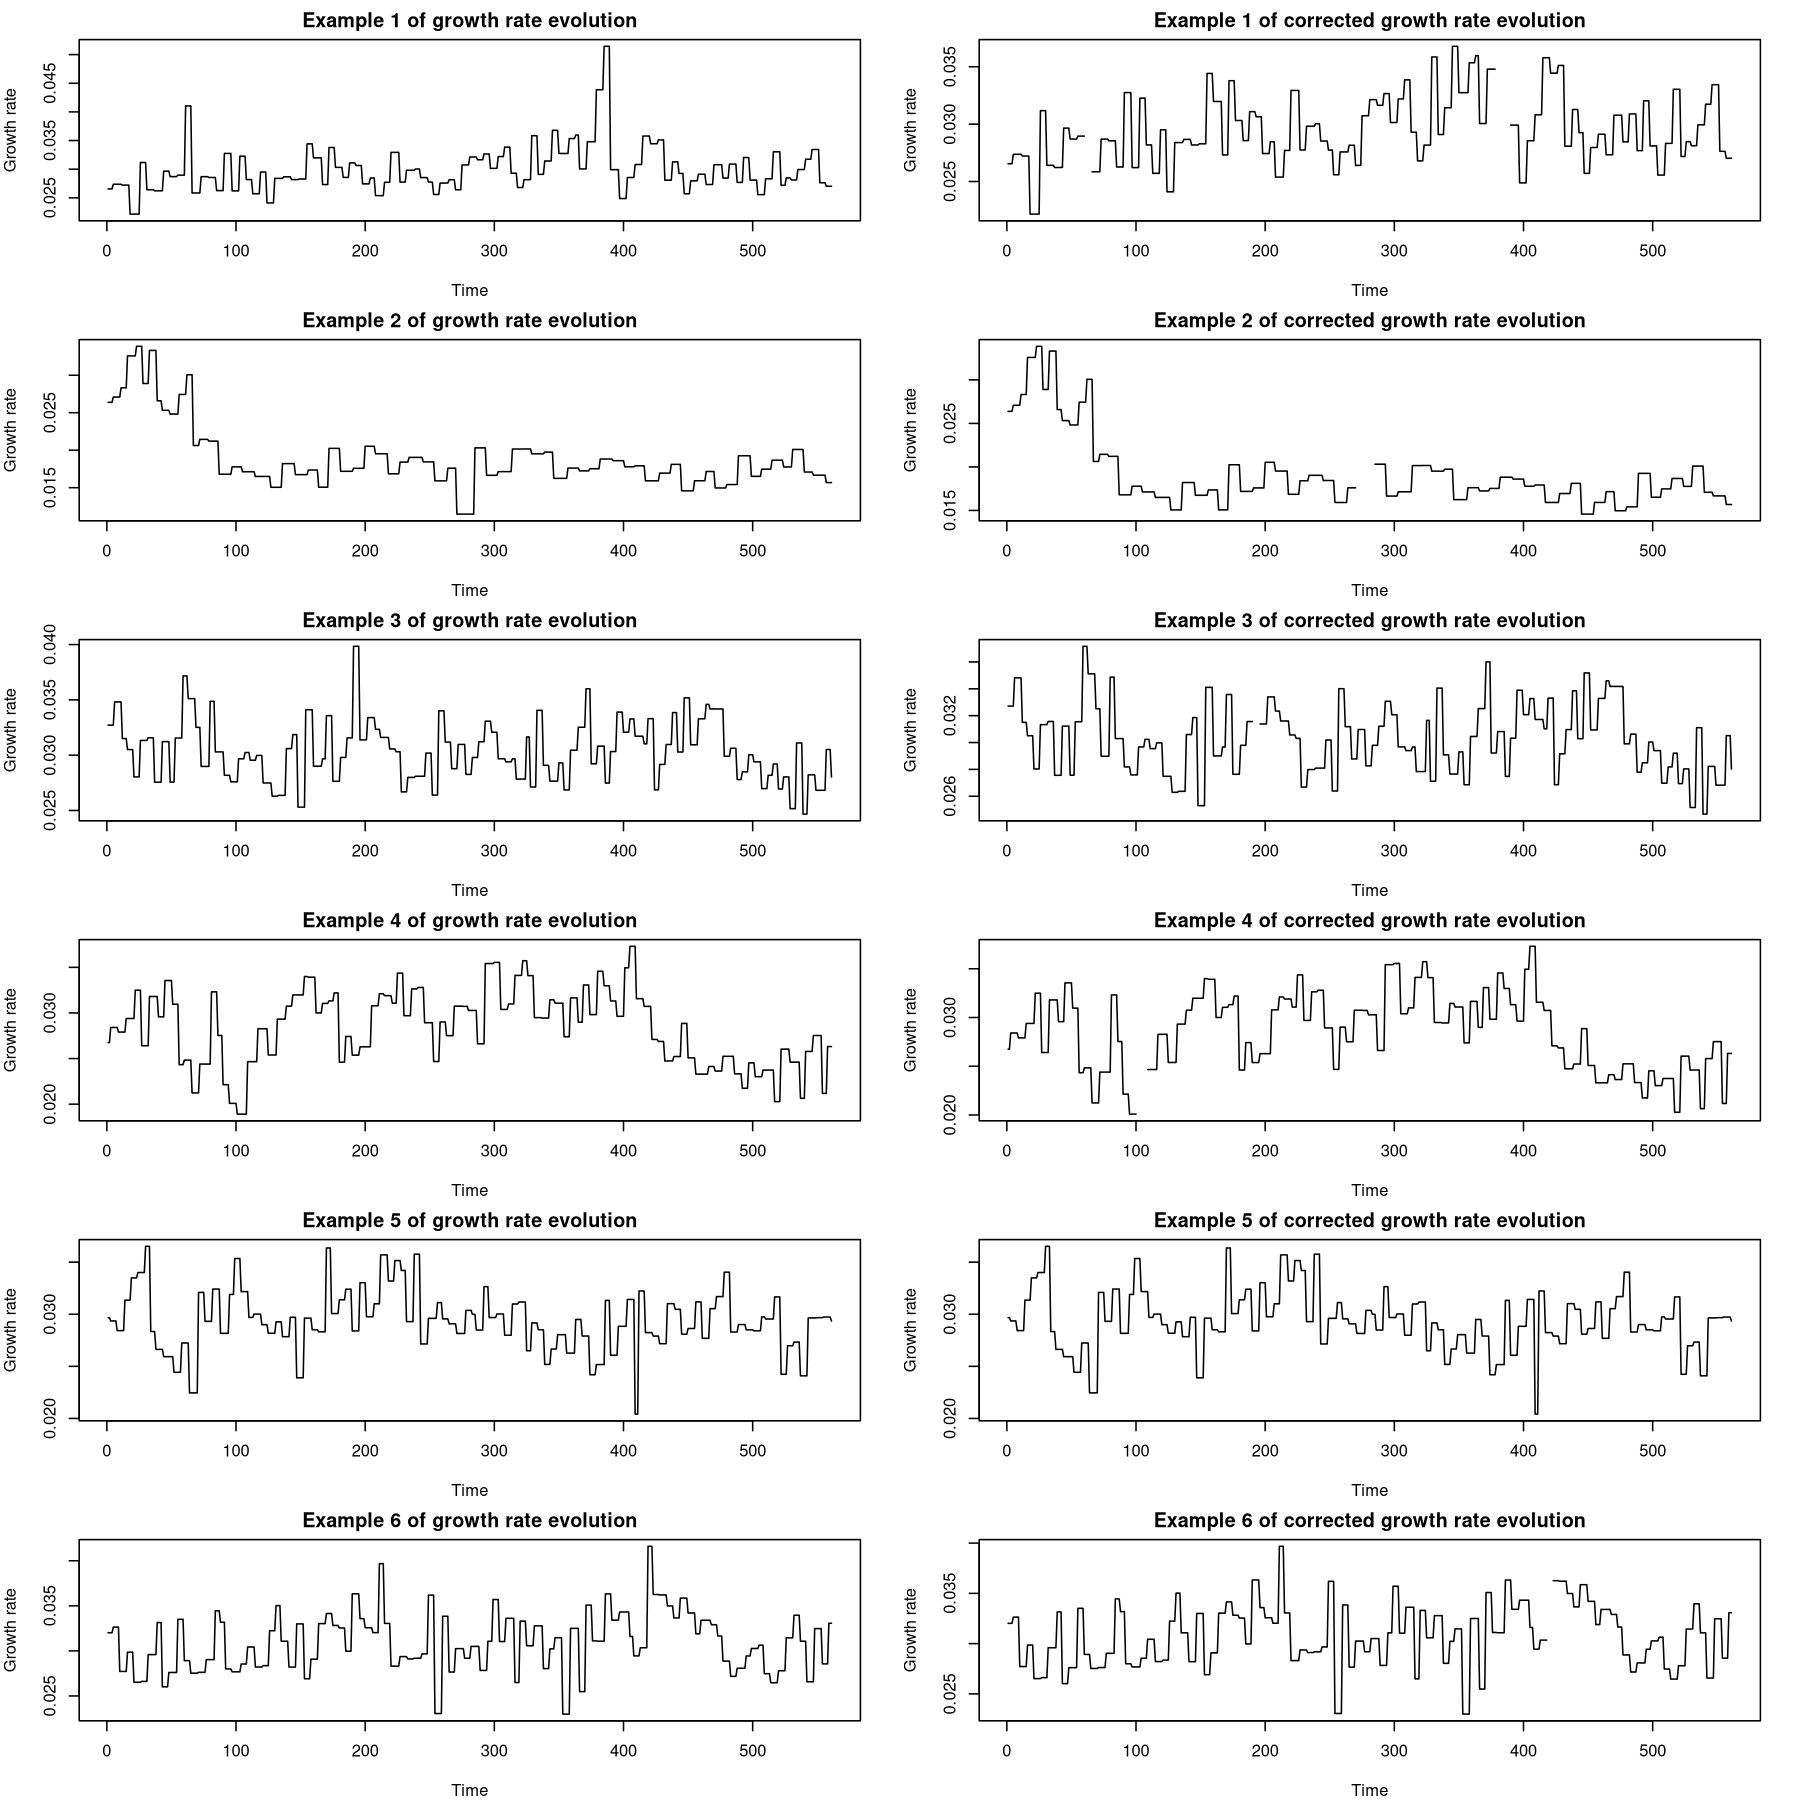

In [75]:
# Let us look at some examples:

par(mfrow=c(6,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

for (i in 1:6){
    plot(microMA_MutH_growthRates[40:600, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(microMA_MutH_growthRates_nodead_noab[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of corrected growth rate evolution"))
}

In [70]:
moment_expectation <- function(k, dataset){
  return (rowMeans(dataset**k, na.rm = T))
}

log_choose <- function(k, n, moments_expectations){
  return ((-1)**k*choose(n,k)*log(moments_expectations[,k]))
}

k_values=1:10
moments_expectations_clean_MutH <- data.frame(sapply(k_values, 
                                                   moment_expectation, 
                                                   dataset=microMA_MutH_growthRates_nodead_noab))
names(moments_expectations_clean_MutH) <- paste("k.", k_values, sep = "")

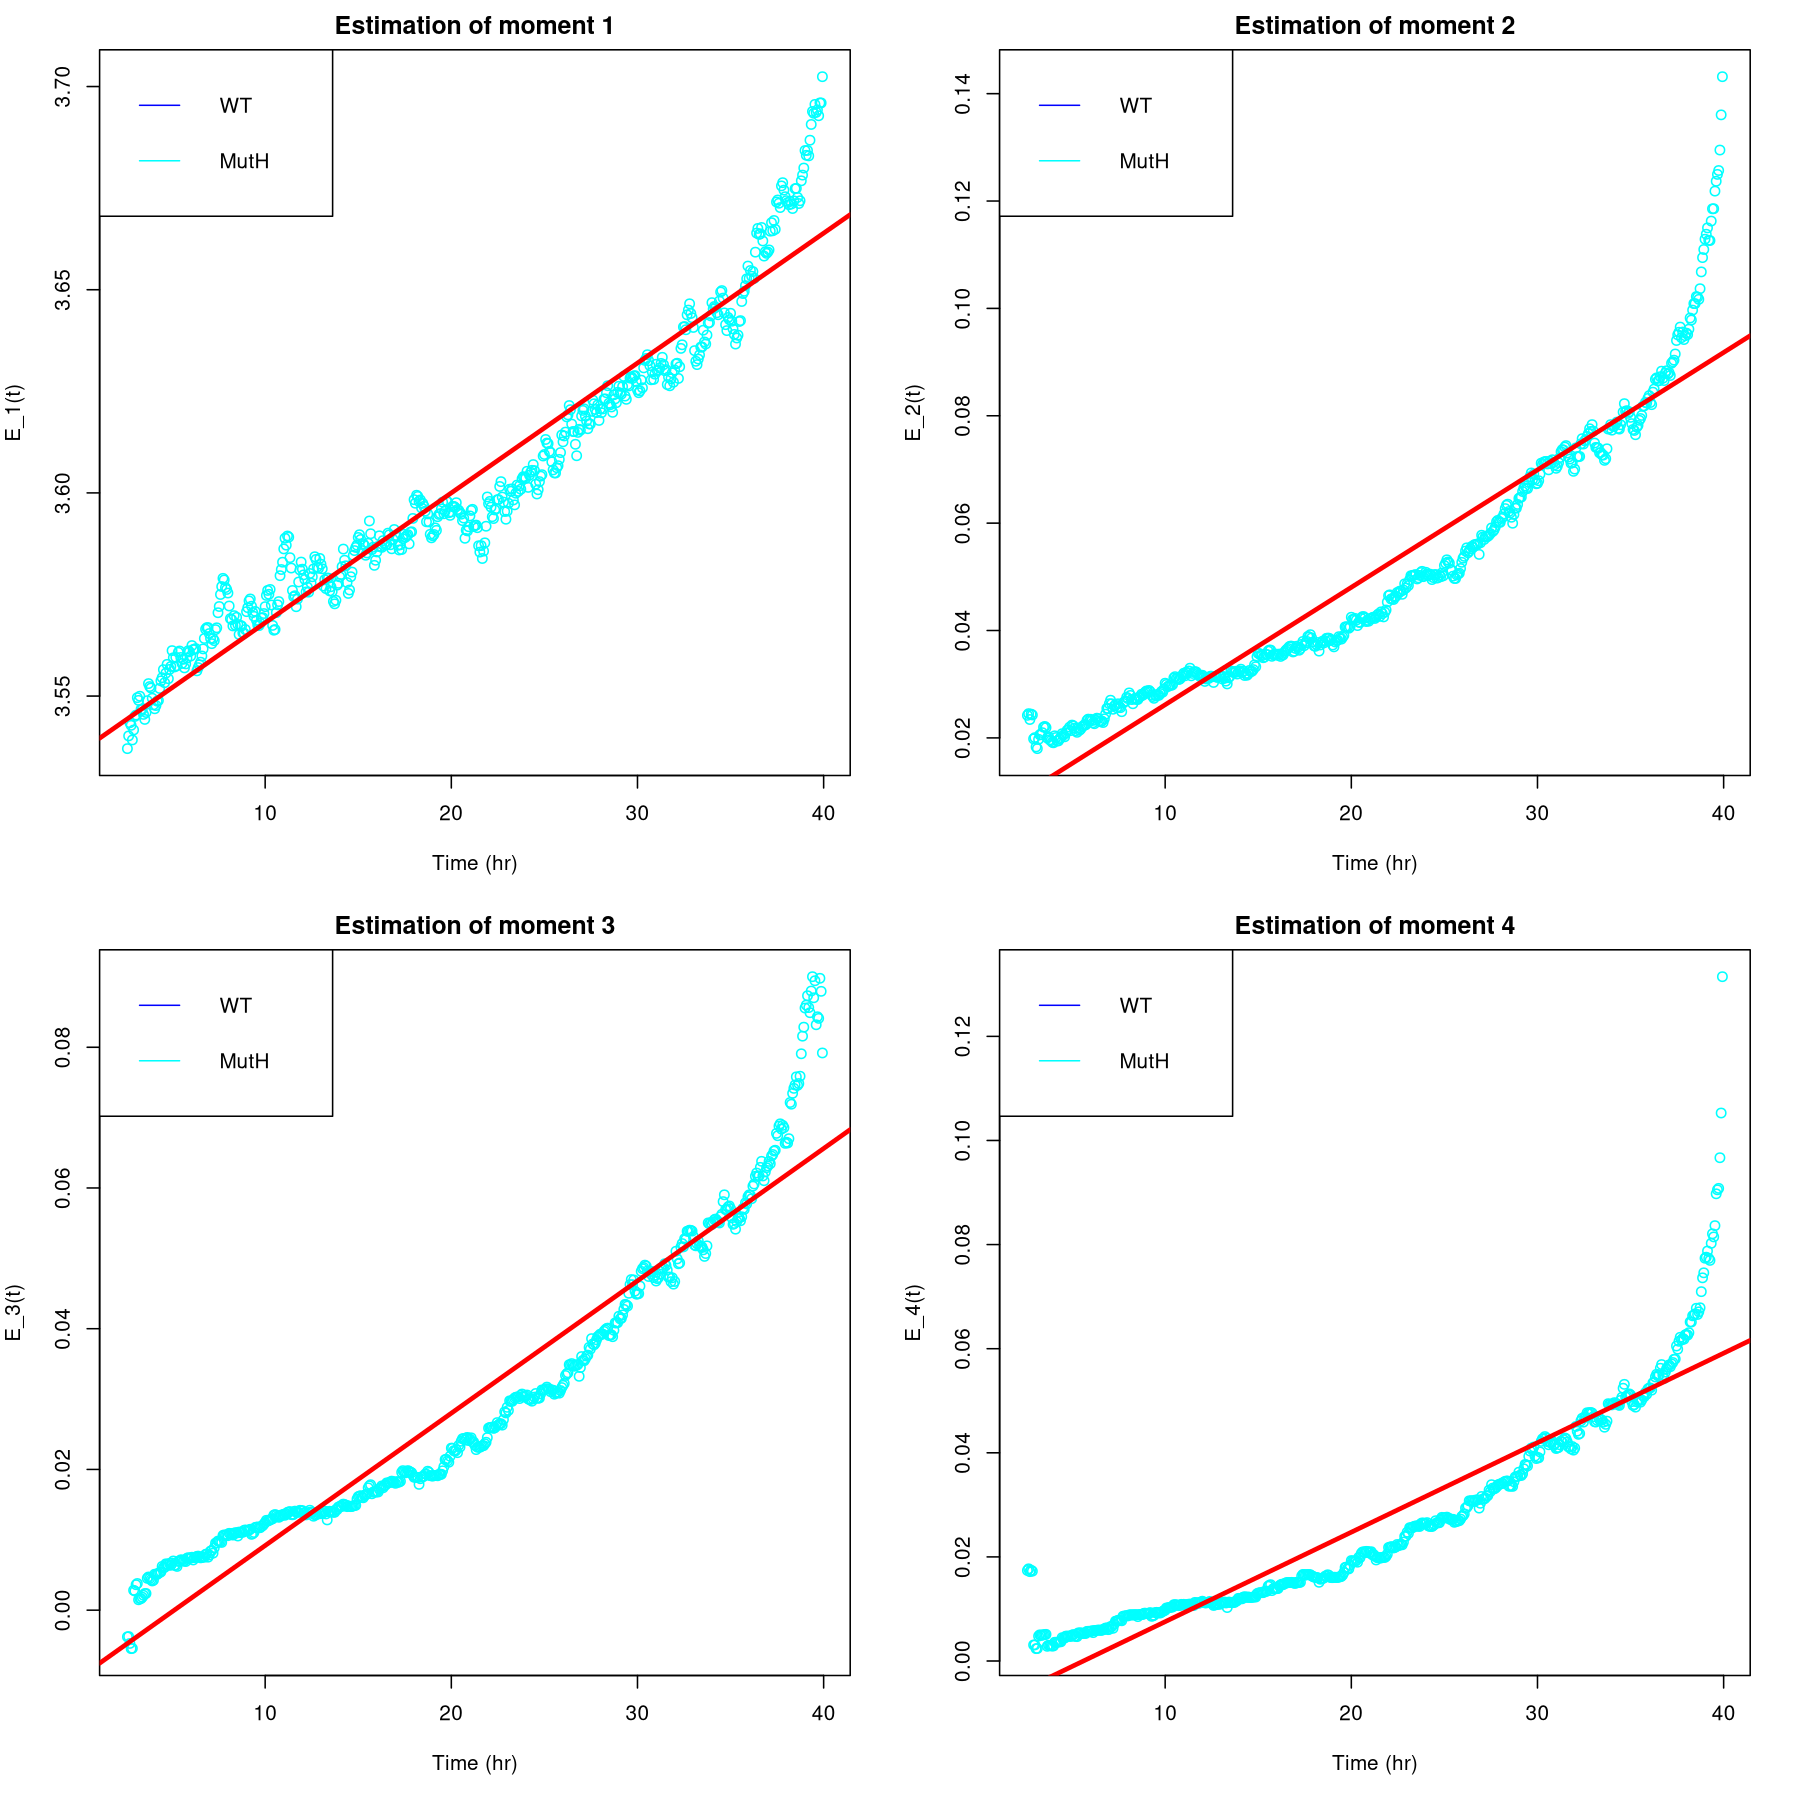

In [73]:
time_window=10:600
par(mfrow = c(2,2), mar = c(5, 4, 2, 2))
#options(repr.plot.width = 12, repr.plot.height = 6)

N <- 4
slopes <- data.frame(n = 1:N,
                     slope_MutH = rep(NA,N), std_err_MutH = rep(NA,N), r2_MutH = rep(NA,N), resid_L1_MutH = rep(NA,N), resid_L2_MutH = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[40:600,]$time/60,
                     E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH)))
    
    plot(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           xlab = "Time (hr)",
           ylab = paste("E_", n, "(t)", sep = ""),
           col = "cyan",
           main = paste("Estimation of moment", n))
    
    lin_reg_MutH <- lm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="red", lwd=3)
    slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=5)
}

In [74]:
signif(slopes, digits=2)

n,slope_MutH,std_err_MutH,r2_MutH,resid_L1_MutH,resid_L2_MutH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.3e-05,5.8e-07,0.94,0.0066,0.0088
2,3.6e-05,5.1e-07,0.90,0.0056,0.0077
3,3.1e-05,3.9e-07,0.92,0.0046,0.0060
4,2.9e-05,4.9e-07,0.86,0.0050,0.0075
